In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import numpy as np
import torch as T
from torch.autograd import Variable
import torch.nn as nn
from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from torch.optim import Adam
import matplotlib.pyplot as plt

In [0]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
seed = 420 
set_global_seeds(seed)

# Neural Net Definition

In [0]:
class LatentCandidate(nn.Module):
    """ The latent space of this autoencoder is one dimensional """
    def __init__(self, input_shape, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.latent_size = latent_size
        
        self.encoder_conv = nn.Sequential(
        nn.Conv2d(self.c, 64, 8, 4),
        nn.ReLU(True),
        nn.Conv2d(64, 32, 4, 2),
        nn.ReLU(True),
        nn.Conv2d(32, 16, 4, 1),
        nn.ReLU(True)
        )

        self.conv_x, conv_f = self.conv_size(self.encoder_conv, input_shape)

        self.encoder_linear = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(conv_f, self.latent_size)
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_size, conv_f),
            nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(16, 32, 4, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 64, 4, 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.c, 8, 4)
        )        

    def conv_size(self, net, in_shape):
        x = Variable(T.rand(1, *in_shape))
        o = net(x)
        b = (-1, o.size(1), o.size(2), o.size(3))
        return b, o.data.view(1, -1).size(1)

    def forward(self, x):
        x = self.encoder_conv(x)
        latent = self.encoder_linear(x)
        x = self.decoder_linear(latent)
        x = x.view(self.conv_x)
        x = self.decoder_conv(x)
        return x, latent

In [0]:
class Latent2dCandidate(nn.Module):
    """ The latent space of this autoencoder is two dimensional """
    def __init__(self, input_shape, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.latent_size = latent_size
        
        self.encoder_conv = nn.Sequential(
        nn.Conv2d(self.c, 64, 8, 4),
        nn.ReLU(True),
        nn.Conv2d(64, 32, 4, 2),
        nn.ReLU(True),
        nn.Conv2d(32, 16, 4, 1),
        nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(16, 32, 4, 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 64, 4, 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.c, 8, 4)
        )        

    def forward(self, x):
        latent = self.encoder_conv(x)
        x = self.decoder_conv(latent)
        return x, latent

In [0]:
env = make_atari_env('BreakoutNoFrameskip-v4', num_env=8, seed=420)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
policy_dim = env.action_space.n
hx,wx,cx=in_dim
in_dim=(cx,hx,wx)

in_dim, policy_dim

((4, 84, 84), 4)

(torch.Size([1, 4, 84, 84]), torch.Size([8, 4, 84, 84]))

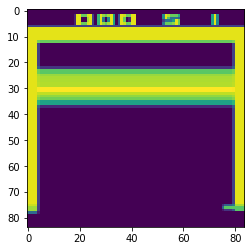

In [0]:
env.reset()
for _ in range(5):
    ob = env.step([1]*8)[0]
plt.imshow(ob[0][:,:,2])

single = T.from_numpy(np.moveaxis(ob[0]/255., 2, 0).astype(np.float32)).unsqueeze(0)
batch = T.from_numpy(np.moveaxis(ob/255., 3, 1).astype(np.float32))
single.size(), batch.size()

Loss:  3.778298918177825e-08


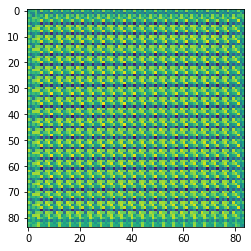

Loss:  3.778298918177825e-08


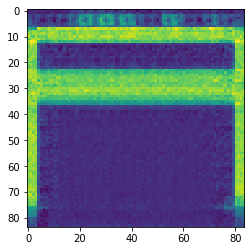

Loss:  3.778298918177825e-08


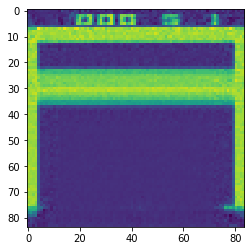

Loss:  3.778298918177825e-08


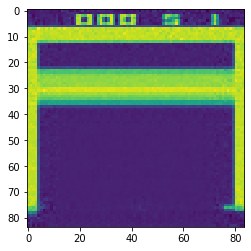

Loss:  3.778298918177825e-08


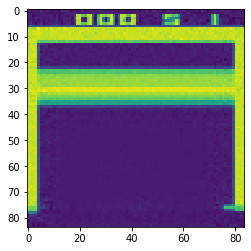

Loss:  3.778298918177825e-08


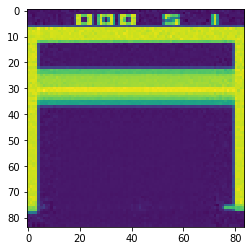

Loss:  3.778298918177825e-08


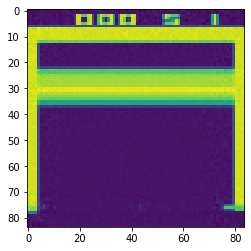

Loss:  3.778298918177825e-08


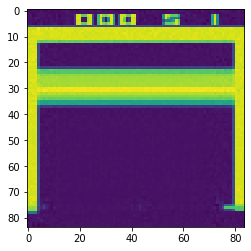

Loss:  3.778298918177825e-08


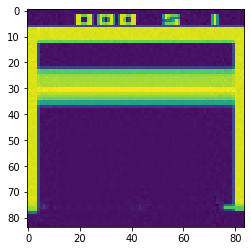

Loss:  3.778298918177825e-08


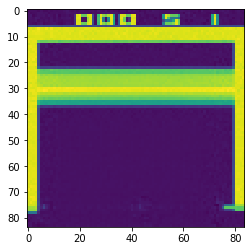

Loss:  3.778298918177825e-08


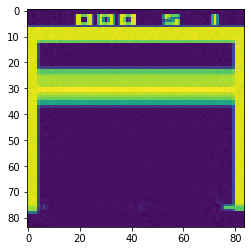

Loss:  3.778298918177825e-08


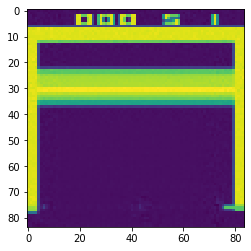

Loss:  3.778298918177825e-08


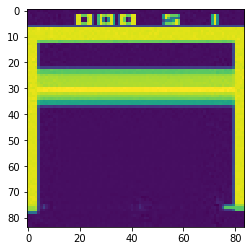

Loss:  3.778298918177825e-08


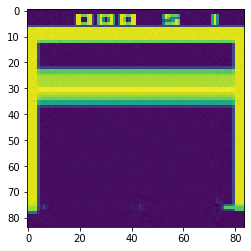

Loss:  3.778298918177825e-08


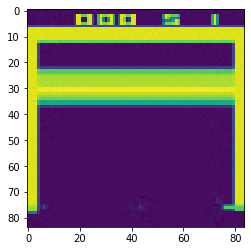

Loss:  3.778298918177825e-08


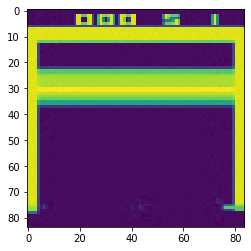

Loss:  3.778298918177825e-08


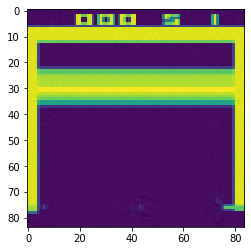

Loss:  3.778298918177825e-08


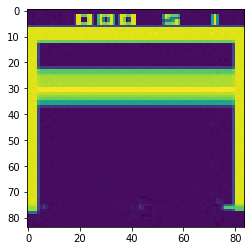

Loss:  3.778298918177825e-08


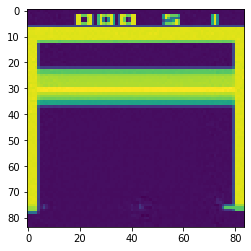

Loss:  3.778298918177825e-08


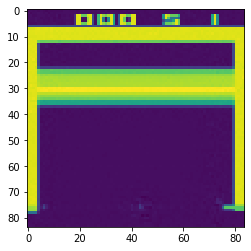

KeyboardInterrupt: ignored

In [0]:
auto_enc = LatentCandidate(in_dim, 256)
optimizer = Adam(auto_enc.parameters(), 7e-4, eps=1e-5)
auto_enc = auto_enc.to(DEVICE)

for i in range(50000):
    
    pred, latent = auto_enc(batch)
    citerion = nn.MSELoss()
    loss = citerion(pred, batch)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(auto_enc.parameters(), 0.5)
    optimizer.step()

    if i % 100 == 0:
        print('Loss: ', loss.item())
        # print('Latent: ', latent)
        plt.imshow(pred.detach().numpy()[0][0])
        plt.show()

Loss:  3.778298918177825e-08


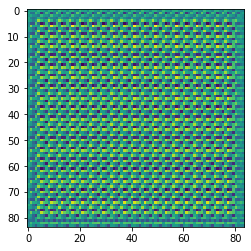

Loss:  3.778298918177825e-08


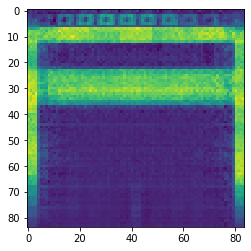

Loss:  3.778298918177825e-08


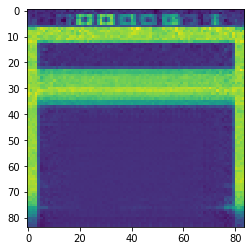

Loss:  3.778298918177825e-08


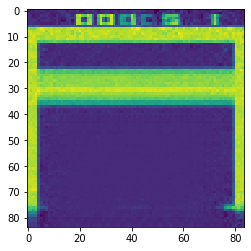

Loss:  3.778298918177825e-08


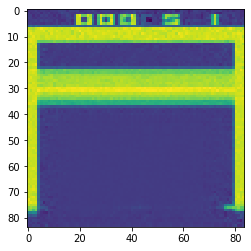

Loss:  3.778298918177825e-08


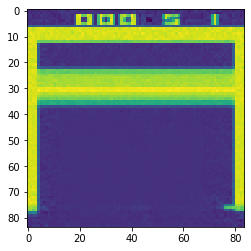

Loss:  3.778298918177825e-08


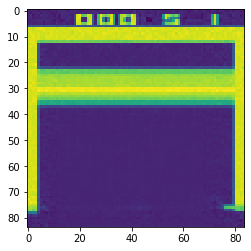

Loss:  3.778298918177825e-08


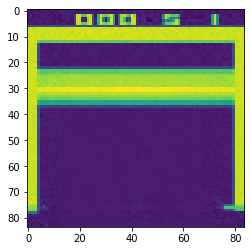

Loss:  3.778298918177825e-08


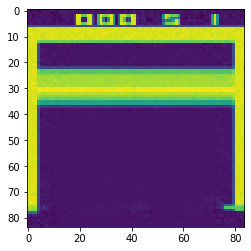

Loss:  3.778298918177825e-08


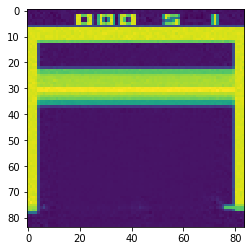

Loss:  3.778298918177825e-08


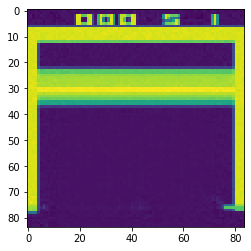

Loss:  3.778298918177825e-08


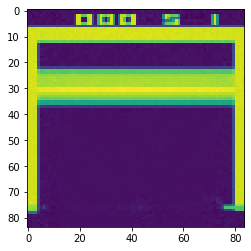

Loss:  3.778298918177825e-08


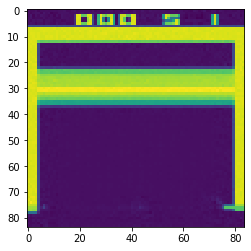

Loss:  3.778298918177825e-08


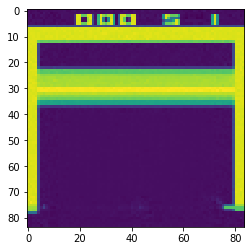

Loss:  3.778298918177825e-08


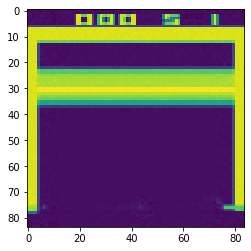

Loss:  3.778298918177825e-08


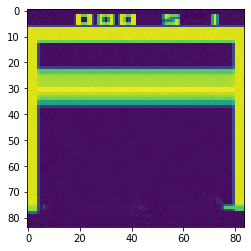

KeyboardInterrupt: ignored

In [0]:
auto_enc = Latent2dCandidate(in_dim, 256)
optimizer = Adam(auto_enc.parameters(), 7e-4, eps=1e-5)
auto_enc = auto_enc.to(DEVICE)

for i in range(50000):
    
    pred, latent = auto_enc(batch)
    citerion = nn.MSELoss()
    loss = citerion(pred, batch)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(auto_enc.parameters(), 0.5)
    optimizer.step()

    if i % 100 == 0:
        print('Loss: ', op.item())
        # print('Latent: ', latent)
        plt.imshow(pred.detach().numpy()[0][0])
        plt.show()